In [45]:
from dotenv import load_dotenv

import os
import tarfile
import urllib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

### Load Data

In [46]:
load_dotenv()

True

In [47]:
HOUSEING_DATA_PATH = os.getenv("HOUSEING_DATA_PATH")

In [48]:
def load_housing_data(housing_path=HOUSEING_DATA_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Explore Data

In [49]:
housing = load_housing_data(HOUSEING_DATA_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [50]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

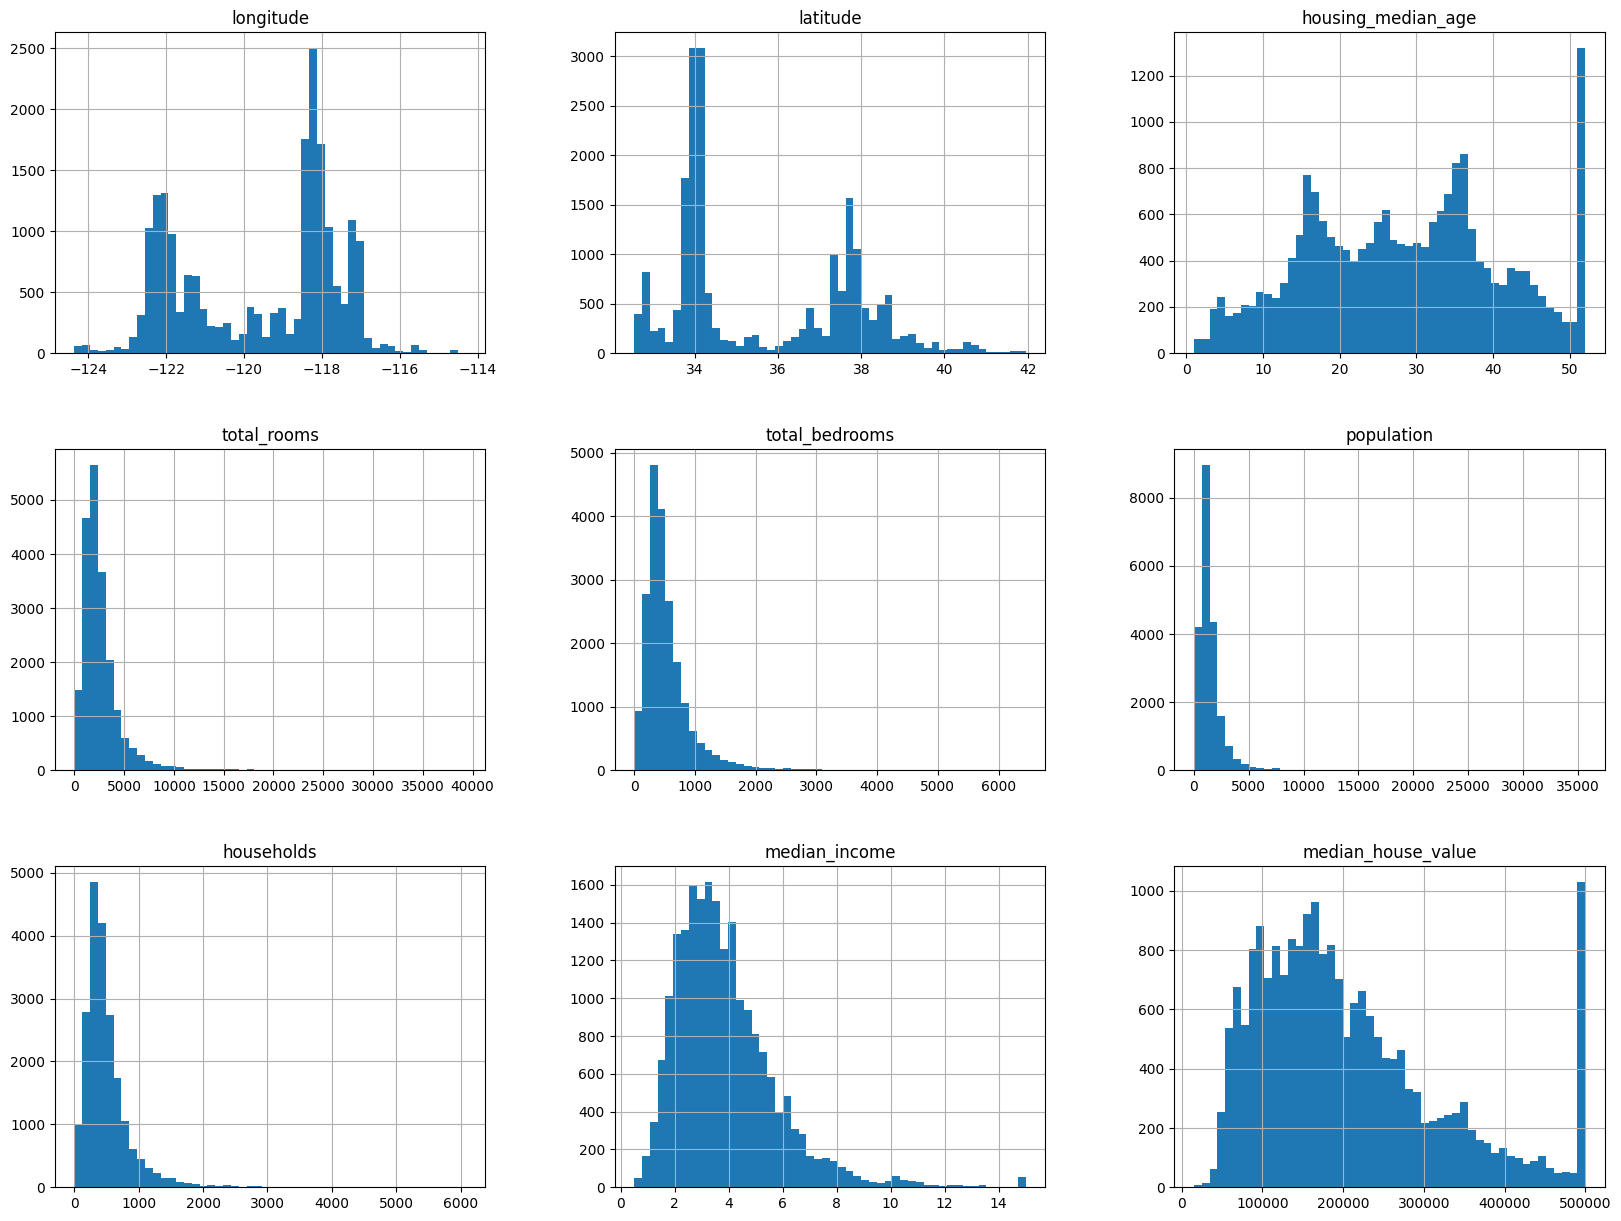

In [51]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Split Data

In [52]:
# Split Data

def split_train_test(data, test_ration):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ration)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [53]:
train_set, test_test = split_train_test(housing, 0.2)

### Instance Split

In [54]:
# Instance’s identifier

from zlib import crc32

def test_set_check(identifer, test_ratio):
    return crc32(np.int64(identifer)) & 0xffffffff < test_ratio * 2 ** 32

In [55]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: test_set_check(id, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [56]:
housing_with_ids = housing.reset_index()
train_set, test_test = split_train_test_by_id(housing_with_ids, 0.2, "index")

### Train and Test Split

In [57]:
# train test split
train_set, test_test = train_test_split(housing, test_size=0.2, random_state=42)

### Feature Engineering - cut

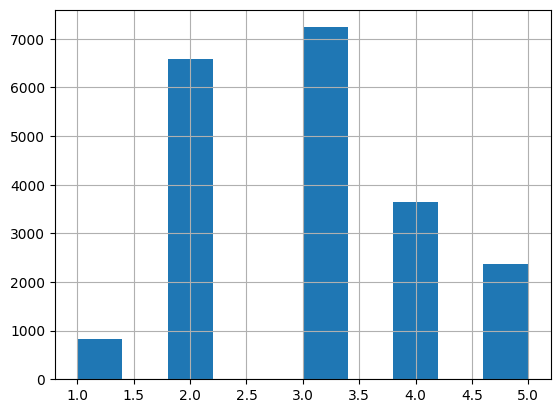

In [58]:
housing['income_cat'] = pd.cut(housing['median_income'],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

housing['income_cat'].hist()
plt.show()

In [59]:
housing['income_cat'].value_counts() / len(test_test)

income_cat
3    1.752907
2    1.594234
4    0.881541
5    0.572190
1    0.199128
Name: count, dtype: float64

###  StratifiedShuffleSplit

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

#### Sampling bias comparison of stratified versus purely random sampling

In [61]:
overall = housing['income_cat'].value_counts() / len(housing)
random = housing['income_cat'].value_counts() / len(test_test)
stratified = strat_test_set['income_cat'].value_counts() / len(strat_test_set)

In [62]:
comparison_df = pd.DataFrame({
    "Overall": overall,
    "Stratified": stratified,
    "Random": random,
}, index=[1, 2, 3, 4, 5])
comparison_df

,Overall,Stratified,Random
1,0.039826,0.039971,0.199128
2,0.318847,0.318798,1.594234
3,0.350581,0.350533,1.752907
4,0.176308,0.176357,0.881541
5,0.114438,0.114341,0.572190


In [63]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [64]:
housing = strat_train_set.copy()

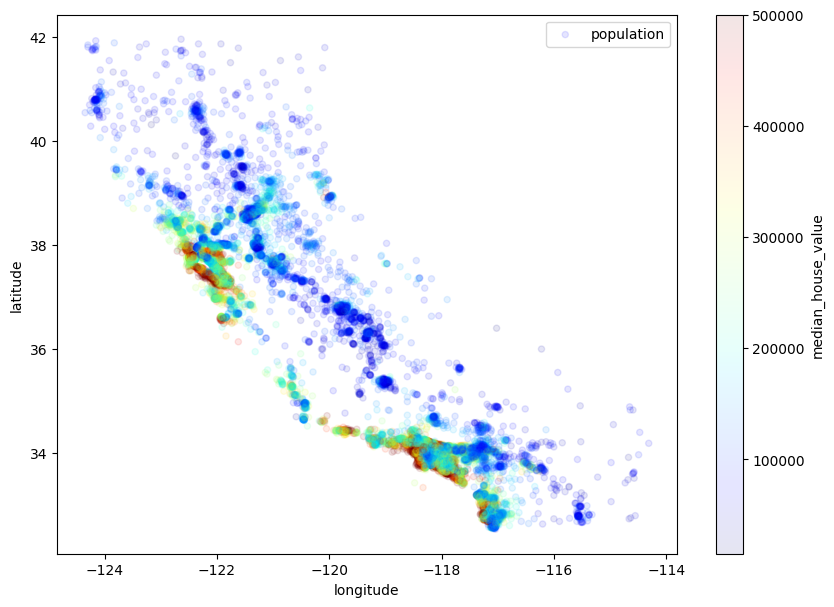

In [72]:
# Visualizing Geographical Data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, label="population", figsize=(10, 7), 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()